In [28]:
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision import datasets
from torchvision.utils import save_image

import skimage 
import math
# import io
# import requests
# from PIL import Image

import numpy as np
import scipy as sp
import scipy.stats as st
import pandas as pd
# import matplotlib.pyplot as plt
import sys
import os


Bibliography:

* [Stacked Convolutional Auto-Encoders for Hierarchical Feature Extraction](http://people.idsia.ch/~ciresan/data/icann2011.pdf)
    

In [2]:
# Mostly Taken from examples here:
# https://github.com/pytorch/examples/blob/master/mnist/main.py
# https://github.com/csgwon/pytorch-deconvnet/blob/master/models/vgg16_deconv.py
# Other resources
# https://github.com/pgtgrly/Convolution-Deconvolution-Network-Pytorch/blob/master/conv_deconv.py
# https://github.com/kvfrans/variational-autoencoder
# https://github.com/SherlockLiao/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main-gpu.py
# https://pgaleone.eu/neural-networks/2016/11/24/convolutional-autoencoders/

In [17]:
class CAEEncoder(nn.Module):
    """
    The Encoder = Q(z|X) for the Network
    """
    def __init__(self, w,h, channels=3, levels=2, kernel_size=3, first_feature_count=16):
        super(CAEEncoder, self).__init__()
        self.width = width
        self.heigth = height
        self.channels = channels
        self.levels = levels
        self.kernel_size = kernel_size
        self.first_feature_count = first_feature_count
        
        self.indices = []
        
        padding = math.floor(kernel_size/2)

        self.l_features = [channels]
        self.layers = []
        
        for i in range(levels + 1):
            l_features.append(first_feature_count * (2**(i)) )
            
        for i in range(levels):
            
            nfeat = self.l_features[i+1]
            layer = nn.Sequential(
                nn.Conv2d(self.l_features[i], nfeat, kernel_size=kernel_size, padding=padding),
                nn.ReLU(),
                nn.Conv2d(nfeat, nfeat, kernel_size=kernel_size, padding=padding),
                nn.ReLU(),
                torch.nn.MaxPool2d(2, stride=2, return_indices=True)
            )
            self.layers.append(layer)
        
        #self.conv_dim = int(((w*h)/ ((2**levels)**2)) * self.l_features[-1])
        self.conv_dim = ((w*h)// ((2**levels)**2)) * self.l_features[-1]

    def forward(self, x):
        self.indices = []
        out = x
        for i in range(self.levels):
            layer = self.layers[i]
            out, idx  = layer(out)
            self.indices.append(idx)
        return out

In [18]:
class CAEDecoder(torch.nn.Module):
    """
    The Decoder = P(X|z) for the Network
    """
    def __init__(self, encoder, width, height, channels=3, levels=2, kernel_size=3, first_feature_count=16):
        super(CAEDecoder, self).__init__()
        padding = math.floor(kernel_size/2)
        self.width = width
        self.heigth = height
        self.channels = channels
        self.levels = levels
        self.encoder = encoder
        
        self.l_features = [channels]
        self.layers = []
        
        for i in range(levels + 1):
            l_features.append(first_feature_count * (2**(i)) )
        
        self.encoder = encoder
        #self.conv_dim = int(((w*h)/ ((2**levels)**2)) * self.l_features[-1])
        self.conv_dim = ((w*h)// ((2**levels)**2)) * self.l_features[-1]

        self.unpool_1 = nn.MaxUnpool2d(2, stride=2)
        self.deconv_layer_1 = torch.nn.Sequential(
            nn.ConvTranspose2d(self.l2_feat, self.l2_feat, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(self.l2_feat, self.l1_feat, kernel_size=kernel_size, padding=padding),
            nn.ReLU()
        )
        self.unpool_2 = nn.MaxUnpool2d(2, stride=2)
        self.deconv_layer_2 = torch.nn.Sequential(
            nn.ConvTranspose2d(self.l1_feat, self.l1_feat, kernel_size=kernel_size, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(self.l1_feat, channels, kernel_size=kernel_size, padding=padding),
            nn.Tanh()
        )

    def forward(self, x):
        out = x
        for i in range(self.levels):
            rev_i = -(i+1)
            out = F.max_unpool2d(out, self.encoder.indices[rev_i],2, stride=2)
            out = self.layers[i](out)
        return out

In [5]:
class CAE(nn.Module):
    def __init__(self, width, height, channels, levels=2, conv_layer_feat=16):
        super(CAE, self).__init__()
        self.width = width
        self.height = height
        self.channels = channels
        self.encoder = CAEEncoder(width, height, channels, levels, 3, conv_layer_feat)
        self.decoder = CAEDecoder(self.encoder, width, height, channels, levels, 3, conv_layer_feat)
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out
        
    def save_model(self, name, path):
        torch.save(self.encoder, os.path.join(path, "cae_encoder_"+name+".pth"))
        torch.save(self.decoder, os.path.join(path, "cae_decoder_"+name+".pth"))
        

In [6]:
def prime_factors(n):
    i = 2
    factors = []
    while i * i <= n:
        if n % i:
            i += 1
        else:
            n //= i
            factors.append(i)
    if n > 1:
        factors.append(n)
    return sorted(factors)

In [7]:
#definitions of the operations for the full image autoencoder
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406], # from example here https://github.com/pytorch/examples/blob/409a7262dcfa7906a92aeac25ee7d413baa88b67/imagenet/main.py#L94-L95
   std=[0.229, 0.224, 0.225]
#   mean=[0.5, 0.5, 0.5], # from example here http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#    std=[0.5, 0.5, 0.5]
)

#the whole image gets resized to a small image that can be quickly analyzed to get important points
def fullimage_preprocess(w=48,h=48):
    return transforms.Compose([
        transforms.Resize((w,h)), #this should be used ONLY if the image is bigger than this size
        transforms.ToTensor(),
        normalize
    ])

#the full resolution fovea just is a small 12x12 patch 
def crop_fovea(size=12):
    sample = transforms.Compose([
    transforms.CenterCrop(size),
    transforms.ToTensor(),
    normalize
    ])
    return sample

def downsampleTensor(crop_size, final_size=16):
    sample = transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.Resize(final_size), 
        transforms.ToTensor(),
        normalize
    ])
    return sample


In [40]:
#From https://stackoverflow.com/questions/29731726/how-to-calculate-a-gaussian-kernel-matrix-efficiently-in-numpy

#TODO improve this to make it from Standard Deviation and kernel size
def get_gaussian_kernel(kernlen=5, nsig=3):
    """Returns a 2D Gaussian kernel array."""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

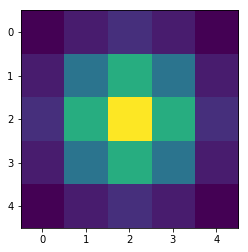

In [41]:
import matplotlib.pyplot as plt
plt.imshow(get_gaussian_kernel(5, 3), interpolation='none')

In [47]:
class DownsampleLayer(nn.Module):
    """
    """
    def __init__(self, width, height):
        super().__init__()
        self.resizer = transforms.Compose([
                        torchvision.transforms.ToPILImage(),  #is this correct? will this be slow??
                        torchvision.transforms.Resize(width, height),
                        torchvision.transforms.ToTensor()
                        ])
    def forward(self, x):
        return self.resizer(x)
        #return self.conv(x)



In [49]:
# NOTE: all patches will be square
# full size image will be resized to a square image, beacause it's easy

class MultiResCAE(nn.Module):
    """
    Multi Resolution group of Convolutional Autoencoders
    This module intends to group several autoencoders that accompany different resolutions
    The goal of this module is be able to train and maintain all the filters in one place
    This model can be saved and loaded as a single element
    This model outputs tensor of dimension 1x1xN that is the concatenation of the output of all the encoders ensemble
    the FULL IMAGE is not considered in this 
    """
    def __init__(self, in_img_shape, channels=3, res_levels=3, conv_layer_feat=[32,16,16], 
                 res_px=[[12,12],[16,16],[20,20]], crop_sizes=[[12,12],[32,32],[64,64]],
                 # conv_sizes = [(3,5,7), (3,5,7,11), (3,5,7,11)],  # this is too much I think
                 conv_sizes = [(3,5,7), (3,5), (3,5)] ):
        """
        @param in_imag_shape : [width, height]  # the input image shape, to be able to pre-compute the transform matrices
        """
        super(CAE, self).__init__()
        self.channels = channels  # number of channels in the input image
        self.res_levels = res_levels  #number of resolution levels (NOT including the full image)
        self.conv_layer_feat = conv_layer_feat  # number of convolutional filters per CAE in the first level
        self.res_px = res_px  # downsampled resolution in pixels for each resolution
        self.conv_sizes = conv_sizes  # conv filter sizes per layer, one encoder per size per layer
        ##
        #compute the maximum number of levels that this resolution can handle, 
        #this will be the parameter given to create the resolution encoder
        self.max_levels = [ prime_factors[min(i)].count(2) for i in res_px]
        ##
        # Pre-computing cropping matrices 
        self.crop_sizes = torch.IntTensor(crop_sizes)  # Ps - Patches sizes -  size of the patch to crop
        self.half_crop_sizes = torch.IntTensor(crop_sizes)  # Ps/2 - Patches half sizes -  half size of the patch to crop, to compute positions
        self.ref_patch =  torch.IntTensor(conv_sizes[:].append(in_img_shape)[::-1]) # RP - Reference Patches
        #pre-compute Patch Dynamic Range (pixel wise)
        self._pdr = self.ref_patch - self.crop_sizes
        # saves the last patch centers
        self._last_centers = None  #make a variable placeholder here
        # saves the last patch ranges
        self._last_px_mins = None
        self._last_px_maxs = None
        ##
        # Actual work is done in the following modules
        #
        self.downsamplers = [DownsampleLayer(w,h) for w,h in res_px]
        self.encoders = []
        self.decoders = []
        
        #separated as functions to be able to later LOAD the encoders instead of creating them each time
        self._create_encoders()
        self._create_decoders()
        
    def _create_encoders():
        for i in range(self.res_levels):
            res_encoders = []
            # Conv Encoder description
            conv_features = self.conv_layer_feat[i]
            l_conv_sizes = self.conv_sizes[i]
            levels = self.max_levels[i]
            # Image size
            c = self.channels
            w,h = self.res_px[i]  # resolution of the image for the encoder

            for j in range(l_conv_sizes):
                enc = CAEEncoder(w, h, c, levels, j, conv_features)
                res_encoders.append(enc)
            self.encoders.append(res_encoders)
        
    def _create_decoders():
        for i in range(self.res_levels):
            res_decoders = []
            # Conv Encoder description
            conv_features = self.conv_layer_feat[i]
            l_conv_sizes = self.conv_sizes[i]
            levels = self.max_levels[i]
            # Image size
            c = self.channels
            w,h = self.res_px[i]  # resolution of the image for the encoder

            for j in range(l_conv_sizes):
                enc = CAEDecoder(self.encoders[i][j], w, h, c, levels, j, conv_features)
                res_decoders.append(enc)
            self.decoders.append(res_encoders)
    
    def compute_patches(crop_centers):
        """
        Computes the ranges that have to be cropped from the input image.
        The computation follows the principles:
         - The inner patches positions are relative to the outer ones, in the corresponding hierarchy
         - The patches can not go off the container image
        
        @param crop_centers MUST be a HalfTensor or FloatTensor
        @returns : (centers, min_points, max_points) two IntTensors with the center and ranges that each patch occupies
        
        The returned elements contain the patches from the bigger to the smaller one
        """
        # formula follows this -> see how to implement it in vector operations to make it faster, or precompute it for a fixed image size
        # x_min = 0 + patch_width/2
        # x_max = full_img.width - patch_width/2
        # x_pos = c * (x_max - x_min) == full_img.width - patch_width
        # patch = img[x_pos - patch_width/2 : x_pos + patch_width/2] (warning on patch size)
        
        self._last_centers = crop_centers * self._pdr  # element wise multiplication
        self._last_px_mins = self._last_centers - self.half_crop_sizes
        self._last_px_maxs = self._last_centers + self.half_crop_sizes
        
        return self._last_centers, self._last_px_mins, self._last_px_maxs
    
    def forward(self, x, crop_centers=torch.HalfTensor([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]])):
        """
        x the input image
        crop_centers, a list of centers c where  c in [0:1],
        centers go from the larger one to the lower one
        """
        full_img = x
        ########################
        # BEGIN Cropping
        ###
        # compute the patches positions
        centers, min_px, max_px = compute_patches(crop_centers)
        # make only one vector out of the needed ones
        ranges = min_px.cat(max_px)  
        # Get all the cropped layers
        crops = []
        # TODO find out how to do this without passing from GPU to CPU and vice versa
        prev_crop = full_img
        for pr in ranges:
            #  pr == pixel_ranges = [x0,y0,x1,y1]
            crop = prev_crop[pr[0]:pr[2],pr[1]:pr[3]]  # crop the input
            crops.append(crop)
            prev_crop = crop
        
        # Reverse the list to compute from the fovea to the other dimensions -> I'm not sure if the computation is done in place or not, so starting from the more detailed one
        crops = crops[::-1]
        # encoded outputs from each resolution layer
        codes = []  
        for i in range(len(crops)):
            layer = crops(i)
            encs = self.encoders[i]  # encoders for the current resolution
            #downsample it as many times as needed (basically the )
            downsampler = self.downsamplers[i]
            layer = downsampler(layer)  
            # apply all the encoders in the corresponding i'th layer
            cds = []  # codes of the corresponding layer (at the same resolution)
            for enc in encs:
                c = enc(layer)
                cds.append(c)
            codes.append(cds)
        # Create a simple embedding (maybe later work with a multinomial probability distribution)
        # The embeddings contain also the crop_centers, the scaling (downsample), 
        #     the zoom (upsample) and the relative crop sizes to the complete image
        
        ###
        # END Encoding
        ########################
        # BEGIN decoding
        ###
        # I'm in doubt here if I should do the reverse process of the encoding for each encoder and then use the outputs to generate the input, 
        # or I should create a single composite decoder that handles the entire reconstruction
        # ... ???
        
        ###
        # END Decoding
        ########################
        return out
        
    def save_models(self, name, path):
        raise NotImplementedError()
        pass
        

In [10]:
# NOTE: all patches will be square
# full size image will be resized to a square image, beacause it's easy

class MultiFullCAE(nn.Module):
    """
    Group of Convolutional Autoencoders for a single input resolution
    The image is treated as monochrome
    
    """
    def __init__(self, channels=1, ds_full_image_cae=True, full_image_size=32, full_img_conv_feat=16, full_conv_sizes=(3,5,7)):
        super(CAE, self).__init__()
        self.channels = channels  # number of channels in the input image
        #this will be the parameter given to create the resolution encoder
        self.levels = prime_factors[full_image_size].count(2)
        self.conv_sizes = conv_sizes  # filter sizes to create for each resolution
        self.ds_full_img_cae = ds_full_image_cae  # indicate if create or not the full image downsample conv encoder
        self.full_image_size = full_image_size  # image to which to redimension the entire input image (if previous is True)
        self.full_img_conv_feat = full_img_conv_feat  # number of convolutional filters to use per layer 
        self.full_conv_sizes = full_conv_sizes  # sizes of the convolutional filters, one encoder per size
        
        self.full_encoders = []
        self.full_decoders = []
        #separated as functions to be able to later LOAD the encoders instead of creating them each time
        self._create_full_encoders()
        self._create_full_decoders()
        
        
    def _create_full_encoders(channels=1):
        for cs in self.full_conv_sizes:
            width = height = self.full_image_size
            channels = self.channels  # although I'm thinking in making this monochrome instead to save processing time
            enc = CAEEncoder(width, height, channels, self.levels, cs, self.full_img_conv_feat)
            self.full_encoders.append(enc)
        
    def _create_full_decoders(channels=1):
        for i in range(self.full_conv_sizes):
            cs = full_conv_sizes[i]
            width = height = self.full_image_size
            channels = self.channels  # although I'm thinking in making this monochrome instead to save processing time
            enc = CAEDecoder(self.full_encoders[i], width, height, channels, self.levels, cs, self.full_img_conv_feat)
            self.full_decoders.append(enc)
        
    def forward(self, x):
        #input = downsampled full image converted to monochrome
        ########################
        # BEGIN Encoding
        ###
        
        # for the moment this full image is computed each time, but in the future this will be 
        #     done ONLY if the input image changes
        #     maybe what we want to work with is only the difference from previous frames -> future when working in dynamic environments
        # encoder full downsampled image
        # 
        # join  all encodings into a single vector
        # END Encoding
        ########################
        #BEGIN decoding
        return out
        
    def save_models(self, name, path):
        raise NotImplementedError()
        pass
        

In [ ]:
tg = transforms.Grayscale()

In [ ]:
tg?

In [ ]:
def get_loaders(batch_size, transformation, dataset = datasets.CIFAR100, cuda=True):

    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
    train_loader = torch.utils.data.DataLoader(
        dataset('../data', train=True, download=True,
                       transform=transformation),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        dataset('../data', train=False, transform=transformation),
        batch_size=batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader


In [ ]:
# Hyper Parameters
# num_epochs = 5
# batch_size = 100
# learning_rate = 0.001

num_epochs = 100
batch_size = 128
learning_rate = 0.0001

In [ ]:
model = CAE(12,12,3,500,200,32).cuda()

criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)


In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 12, 12)
    return x


In [ ]:
transformation = full_resolution_crop
train_loader, test_loader = get_loaders(batch_size, transformation)

In [ ]:
%%time

for epoch in range(num_epochs):
    for i, (img, labels) in enumerate(train_loader):
        img = Variable(img).cuda()
        # ===================forward=====================
#         print("encoding batch of  images")
        output = model(img)
#         print("computing loss")
        loss = criterion(output, img)
        # ===================backward====================
#         print("Backward ")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        in_pic = to_img(img.cpu().data)
        save_image(pic, './cae_results/2x2-2xfc-out_image_{}.png'.format(epoch))
        save_image(in_pic, './cae_results/2x2-2xfc-in_image_{}.png'.format(epoch))
    if loss.data[0] < 0.15: #arbitrary number because I saw that it works well enough
        break


model.save_model("2x2-2xfc-layer", "CAE")

## Preliminary Results 

Experiments with the following configurations:
- 2 layers with 2 convolutional stages each  <- **best result**
- 2 layers with 2 convolutional stages each and 2 fully connected layers  <- bigger model and a bit slower to converge, but results are good too
- 2 layers with 2 convolutional stages each with batch normalization
- 2 layers with 4 convolutional stages each <- **worst result**


2 layers with 4 conv stages each does not give the same results as 2 layers with 2 conv stages

It not only converges MUCH faster and the models are smaller, but the actually the convergence is much better

For bathc normalization happens the same, without batchnorm2d converges faster and model is smaller